## MLearn 210: Final Project - Local Outlier Factor Report
#### December 10, 2018
#### Kei Sato

Local Outlier Factor (LOF) is unsupervised learning algorithm for anomaly detection that utilizes the local density of a data point.  The algorithm calculates the local density of each point, a measure of how crowded the area around the observation is, and gives that datapoint an LOF score.  The LOF score is the ratio of the data point's density and the average density of x neighbors (x is a parameter).  If a data point has an LOF greater than 1, then its neighbors have a higher local density than the data point and it is an outlier. While there are other anomaly detection algorithms, LOF addresses the problem of a data point being a local outlier, which is an a outlier relative to its surrounding points instead of relative to the entire dataset.  This maybe be useful to flag data points that would otherwise not be considered outliers because their values may be close to the global average feature attribute values, but the points themselves are not in any clusters.

To determine the LOF of a datapoint, the local reachability density has to be calculated using the using k-distance, reachability distance, and min-points.

#### The k-distance of a data point is defined as:

    For any positive integer k, the k-distance of object p, denoted as k-distance(p), is defined as the distance d(p,o) between p and an object o ∈ D such that:				
        (i) for at least k objects o’∈D \ {p} it holds that d(p,o’) ≤ d(p,o), and
        (ii) for at most k-1 objects o’∈D\{p} it holds that d(p,o’) < d(p,o).
<sup>1</sup>

Given this definition, if k = 3, the k-distance of point p is the distance from p to its third closest neighbor

#### The reachability distance is defined as:
    (reachability distance of an object p with respect to object o)
            Let k be a natural number. The reachability distance of object p with respect to object o is defined as
            reach-distk(p, o) = max { k-distance(o), d(p, o) }.
<sup>2</sup>

The reachability distance between datapoint p with respect to datapoint o is either the actual distance between two data points or the k distance of p, whichever is larger.  If p is within the k-distance neighborhood of o, then its reachability distance with respect to o is the k-distance of o.  If k = 3, then for the 2nd nearest neighbor of point p, the reachability distance of that datapoint with respect to p will be the k-distance of p (the distance from p to its 3rd nearest neighbor).  The reachability distance is a smoothing factor meant to decrease sensitivity in the algorithm.  

We later define minpoints, which is a parameter to specify the volume for the local reachability density.  Minpoints is greater than or equal to k.  Simplified LOF is a variation on LOF for which k is the same as minpoints, and we always use the actual distance between points as the reachability distance.  Simplified LOF is slightly more sensitive and may give less consistent results with regard to inliers.

#### The local reachability density:

The local reachability density of object p

$$lrd_{MinPts}(p) = 1/{\frac{\sum\limits_{o\in{N_{MinPts(p)}}}{reach-dist_{MinPts}(o,p)}}{| N_{MinPts}(p) |}}$$
<sup>3</sup>

Given a value for minpoints, the local reachability density for point p is the inverse of it average reach distance over minpoints number of neighbors.

#### Local Outlier Factor

The local outlier factor for a point p

$$LOF_{MinPts}(p) = \frac{\sum\limits_{o\in{N_{MinPts}(p)}}{\frac{lrd_{MinPts}(o)}{lrd_{MinPts}(p)}}}{|N_{MinPts}(p)|}$$
<sup>4</sup>

With this definition, the LOF of a point p is the average ratio of it’s local reachability density and that of its minpoints neighbors.  If a data point has an LOF around 1, then its density is similar to its neighbors, while if its LOF greater than 1, then its density is much lower than that of its neighbors and it may be an outlier.

The LOF has been applied to the sklean Boston dataset below to demonstrate the use of LOF.  The Boston dataset is a collection of attributes of different towns around Boston, such as the average age or size of houses there, and the median home price of the town.  For the following demo, the predictor value is the per capita crime rate by town and the target value is the median value of owner-occupied homes in the $1000s.

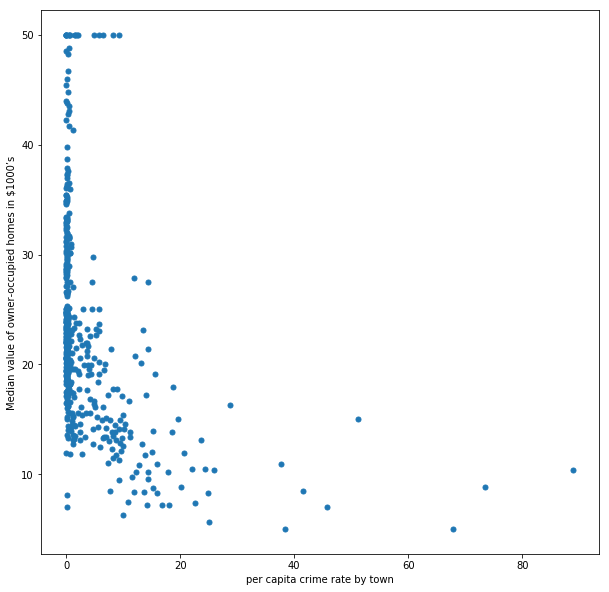

In [4]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

boston = load_boston()
data = pd.DataFrame(boston.data, columns = boston['feature_names'])
data['MEDV'] = boston.target
data.head()

plt.figure(figsize=(10, 10))
plt.scatter(data.loc[:, 'CRIM'], data.loc[:, 'MEDV'], marker='o', s=25)
plt.xlabel("per capita crime rate by town")
plt.ylabel("Median value of owner-occupied homes in $1000’s")
plt.show()


From the plot we can see that there is an inverse relationship between the median home price and the per capita crime rate in a town.  Towards the lower right of the graph are some towns with exceptionally high crime rates, which we would consider outliers.
Red dots are the outliers while blue dots are the inliers

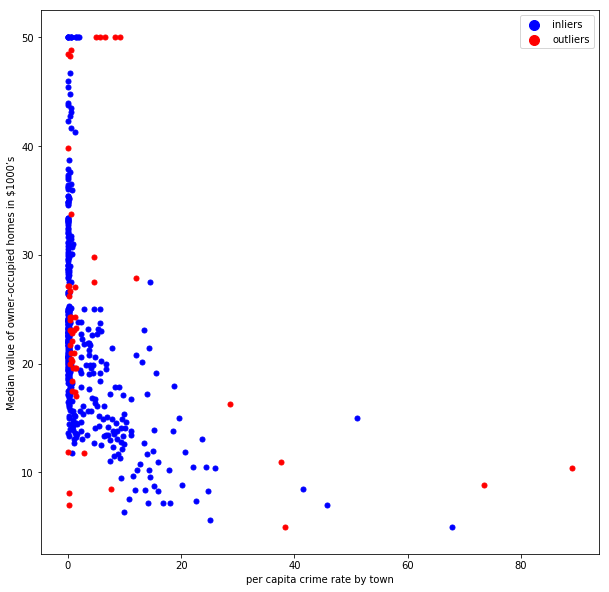

In [2]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=5)
prediction = clf.fit_predict(data[['CRIM', 'MEDV']])


inliers_array = list(map(lambda x: True if x == 1 else False, prediction))
outliers_array = list(map(lambda x: False if x == 1 else True, prediction))

plt.figure(figsize=(10, 10))
plt.scatter(data[inliers_array].loc[:, 'CRIM'], data[inliers_array].loc[:, 'MEDV'],
            c='b', marker='o', s=25, label='inliers')
plt.scatter(data[outliers_array].loc[:, 'CRIM'], data[outliers_array].loc[:, 'MEDV'],
            c='r', marker='o', s=25, label='outliers')

plt.xlabel("per capita crime rate by town")
plt.ylabel("Median value of owner-occupied homes in $1000’s")

legend = plt.legend(loc='upper right')
legend.legendHandles[0]._sizes = [100]
legend.legendHandles[1]._sizes = [100]

X_scores = clf.negative_outlier_factor_
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.show()


This example shows the Sklearn LOF predictor run against the dataset with num_neighbors = 5 and using the simpliefied LOF algorithm, because that is the default option with Sklearn.  While many of the towns with per capita crime rates greater than 40 still marked as outliers, several were considered inliers because they had a similar enough LOF to 5 of its neighbors.  In contrast, many datapoints with low crime rates but high home values considered outliers.  This is because, compared to towns of similar average home prices, those towns had higher crime rates.

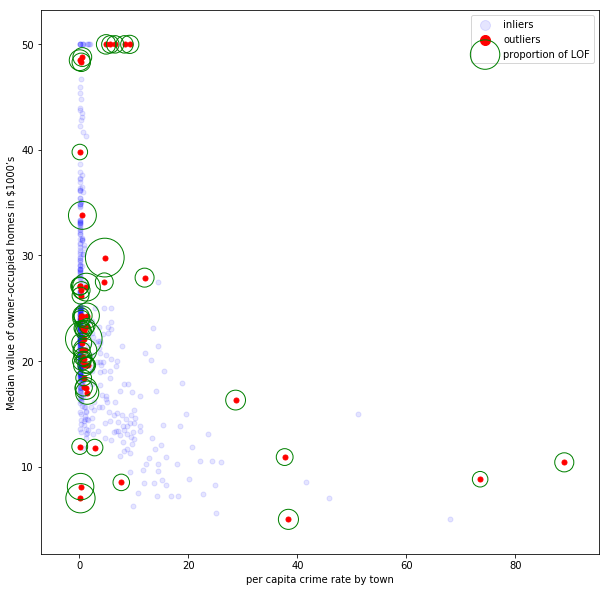

In [3]:
plt.figure(num=3, figsize=(10, 10))
plt.scatter(data[inliers_array].loc[:, 'CRIM'], data[inliers_array].loc[:, 'MEDV'], c='b', marker='o', s=25, alpha=.1, label='inliers')
plt.scatter(data[outliers_array].loc[:, 'CRIM'], data[outliers_array].loc[:, 'MEDV'], c='r', marker='o', s=25, label='outliers')
plt.scatter(data[outliers_array].loc[:, 'CRIM'], data[outliers_array].loc[:, 'MEDV'], s=1500 * radius[outliers_array], facecolors='none', edgecolors='g', label='proportion of LOF')


legend = plt.legend(loc='upper right')
legend.legendHandles[0]._sizes = [100]
legend.legendHandles[1]._sizes = [100]

plt.xlabel("per capita crime rate by town")
plt.ylabel("Median value of owner-occupied homes in $1000’s")
plt.show()

This is the same graph as above but with green radii around the outliers that are proportional to how much of an outlier that datapoint is.  We can see that even in the very dense area near the 0 crime rate observations, there is still a datapoint that is considered more of an outlier than even the datapoint all the way to the right of the graph.  This may be because simplified LOF is more sensitive to inliers or because the towns of 0 crime rate have such similar home prices that even a small deviation may make a datapoint an anomaly.

The main advantage of LOF is that it recognizes local outliers that may not be found by other anomaly detection algorithms.  Because LOF is always a ratio of the density of a point and the density of its neighbors points, it will inherently be a local comparison.  Other outlier detection strategies may look for outliers using a global average and will not find such local anomalies.  Another advantage of LOF is that it can be extended for use in high dimensional data.  For example, LOF was one of the highest performing algorithms when used to detect network intrusion, for which there were 23 features to be analyzed.<sup>5</sup>  LOF is also easy to apply to many different datasets.

The main disadvantage to LOF is that it is difficult to determine at what value an LOF score is indicative of a datapoint being an outlier.  In some datasets, a score of 1.1 may mean it’s a strong outlier, while in others a score of 2 could mean that it is similar to other observations throughout the dataset.  This is the result of not comparing data globally but is probably a common problem with unsupervised learning techniques in general.  Some ways to mitigate this are applying LOF in an ensemble learning approach or other extensions of LOF, such as Local Outlier Probability, which returns a value between 0 and 1 to indicate the likelihood that an observation is an anomaly.  Another negative to LOF is that it can be computationally intensive.  However, this was mentioned more in earlier papers and a more recent reference to the algorithm said that because of advances in hardware, this was no longer an issue.  

The Breunig paper concludes with some suggestions on how to expand LOF and how to apply it correctly.  They suggested looking at clusters whose outliers were close to 1 or very far away from 1, to do more data exploration on why certain clusters had higher or lower density.  It was also mentioned that in high dimension datasets, using different subsets of the attributes may predict different datapoints to be outliers or inliers.  Both ideas suggest that LOF can be as useful in data exploration as it is in anomaly detection.


#### Footnotes
<sup>1</sup>Markus M. Breunig, Hans-Peter Kriegel, Raymond T. Ng, Jörg Sander 2000, 3

<sup>2</sup>Markus M. Breunig, Hans-Peter Kriegel, Raymond T. Ng, Jörg Sander 2000, 3

<sup>3</sup>Markus M. Breunig, Hans-Peter Kriegel, Raymond T. Ng, Jörg Sander 2000, 4

<sup>4</sup>Markus M. Breunig, Hans-Peter Kriegel, Raymond T. Ng, Jörg Sander 2000, 4

<sup>5</sup>Lazarevic, A., Ozgur, A,; Ertoz, L., Srivastava, J., Kumar, V. 2003, 6

#### Bibliography
Breunig, Markus M., et al. “Lof.” Proceedings of the 2000 ACM SIGMOD International Conference on Management of Data - SIGMOD '00, 2000

Lazarevic, Aleksandar, et al. “A Comparative Study of Anomaly Detection Schemes in Network Intrusion Detection.” Proceedings of the 2003 SIAM International Conference on Data Mining, 2003, pp. 25–36.

Wenig, Phillip. “Local Outlier Factor for Anomaly Detection – Towards Data Science.” Towards Data Science, Towards Data Science, 5 Dec. 2018, towardsdatascience.com/local-outlier-factor-for-anomaly-detection-cc0c770d2ebe.

“Local Outlier Factor.” Wikipedia, Wikimedia Foundation, 25 Nov. 2018, en.wikipedia.org/wiki/Local_outlier_factor.
